In [311]:
import sys
sys.path.append('../..')
%load_ext autoreload
%autoreload 2
import spatialpy
import numpy
import matplotlib.pyplot as plt
from matplotlib import rc
import math
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
class All(spatialpy.Geometry):
    def inside(self, x, on_boundary):
        return True

class Walls(spatialpy.Geometry):
    ''' Outside of the unit square'''
    def inside(self, x, on_boundary):
        if x[0] < 0.0 or x[0] > 1.0 or \
           x[1] < 0.0 or x[1] > 1.0:
            return True
        return False

In [252]:
class Simple_Diffusion(spatialpy.Model):
    """ 2D diffusion problem
    Description: box with Dirichlet boundary conditions in all 4 walls
    Top wall: concentration c_high
    All other walls: concentration c_low
    Wall lengths: height = 1, width = 1 (2D case)
  
                 cHigh
              __ __ __ __
             |           |
             |           |
       cLow  |           |  cLow
             |           |
             |__ __ __ __|
             
                 cLow
    
    """

    
    
    def __init__(self, model_name="simple_diffusion"):
        spatialpy.Model.__init__(self,model_name)
        
        
        # System constants
        cHigh = 1.           # concentration of species A on top wall
        cLow  = 0.           # concentration of species A on left, right and bottom walls
        nxF,nyF = 50,50      # number ofparticles in x and y-direction
        nu  = 0.1            # fluid viscosity
        L   = 1.             # characteristic lenght of the cavity (= width = height)
        nW  = 3              # number of wall points
        rho0 = 1.            # reference fluid density
        D = 0.01             # diffusion rate

        # Discretization
        nxTot = nxF + 2*(nW-1) # total number of particles in x-direction (including walls)
        nyTot = nyF + 2*(nW-1) # total number of particles in y-direction (including walls)
        
        # Compute domain bounds (including the boundary)
        dx,dy = L/(nxF-1),L/(nyF-1)
        xLim = ((0-(nW-1)*dx),1+(nW-1)*dx)
        yLim = ((0-(nW-1)*dy),1+(nW-1)*dy)
        print(dx,dy)
        print(xLim,yLim)
        
        # Compute volume and mass per particle
        vol = (xLim[1]-xLim[0])*(yLim[1]-yLim[0])*1.0  # in 2D simulations, consider z-lenght = 1
        mPP = rho0*vol/(nxTot*nyTot)                   # density * total volume / total number of particles

        # Define Species
        self.add_species(spatialpy.Species('A', diffusion_constant=D))

        # Create mesh object
        self.mesh = spatialpy.Mesh.create_2D_domain(
            xLim ,yLim , nxTot, nyTot, 
            type_id=1, mass=mPP, rho0 = rho0, fixed=True)

        
        # Define Subdomains
        self.add_subdomain(All(), 1, mass = mPP, fixed=False)  # total subdomain, type 1
        self.add_subdomain(Walls(), 2, mass = mPP, fixed=True) # lid subdomain, type 2

        
        
        # We might want to add a way to impose intial conditions here (for determ. species)
        # ...
        
        
        # Boundary conditions
        # Bottom wall
        self.add_boundary_condition(spatialpy.BoundaryCondition(
            ymin     = yLim[0],
            ymax     = yLim[0]+(nW-1)*dy,
            species = 'A',
            deterministic=True,
            value    = cLow
        ))
        # Left wall
        self.add_boundary_condition(spatialpy.BoundaryCondition(
            xmin     = xLim[0],
            xmax     = xLim[0]+(nW-1)*dx+1e-12,
            species = 'A',
            deterministic=True,
            value    = cLow
        ))
        # Right wall
        self.add_boundary_condition(spatialpy.BoundaryCondition(
            xmin     = xLim[1]-(nW-1)*dx,
            xmax     = xLim[1],
            species = 'A',
            deterministic=True,
            value    = cLow
        ))
        # Top wall
        self.add_boundary_condition(spatialpy.BoundaryCondition(
            ymin     = yLim[1]-(nW-1)*dy,  # top nW rows of particles
            ymax     = yLim[1],
            species = 'A',
            deterministic=True,
            value    = cHigh
        ))
        
        # Initial conditions (for discrete stochastic species)
        # Place the A molecules in the voxel nearest the center of the square
        #self.add_initial_condition(
        #    spatialpy.PlaceInitialCondition(A,100000,[0,0,0])
        #)
        #self.timespan(numpy.linspace(0,5,1000))

In [253]:
# Creates the model object
model = Simple_Diffusion()

0.02040816326530612 0.02040816326530612
(-0.04081632653061224, 1.0408163265306123) (-0.04081632653061224, 1.0408163265306123)
totalvolume 1.1699291961682634


In [254]:
# Define time parameters
model.timestep_size = 1e-4  # timestep size
model.num_timesteps = 10000    # number of timesteps
model.output_freq = 1000      # frequency of outputting results

In [255]:
# Run the model object
%time result = model.run()

CPU times: user 55.8 s, sys: 1.21 s, total: 57 s
Wall time: 6min 47s


In [257]:
# Plot_step access the result object and search for the specified key to plot
def plot_step(key='type',index=0,time=0):
    pts, data = result.read_step(time)
    plt.figure(figsize=(15,10) )       
    if (key == 'v'):
        d = data[key]
        d = [d[i][index] for i in range(0,len(d))]
        print(len(d))
    else:
        d = data[key]
        print(len(d))
    plt.scatter(pts[:,0],pts[:,1],c=d)
    plt.axis('equal')
    plt.colorbar()
    plt.title('t={0}'.format(time))
    plt.grid(linestyle='--', linewidth=1)
    #plt.set_cmap('viridis') 


def plot_all(key='type'):
    for i,t in enumerate(result.get_timespan()):
        plot_step(i,key)

read_step(10) opening '/var/folders/j0/bp87lk4162s4mjph030rc6hh0000gn/T/spatialpy_result_2hfeelkq/output10000.vtk'
2916


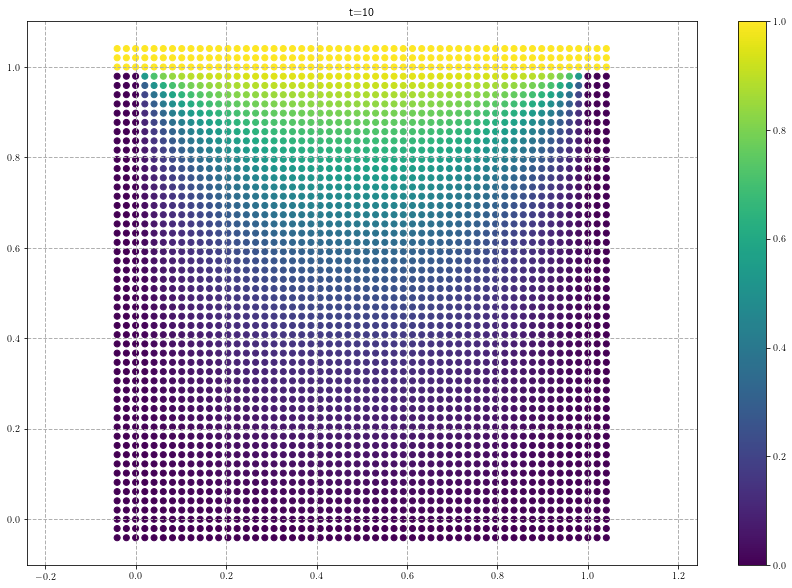

In [314]:
# Plot concentration of species A (discrete) at timestep 100
plot_step('C[A]',time=10)

## Validation:

The steady-state analytical solution is known and has the form

$$C(x,y) = \sum_{n=1}^{\infty} \frac{2 C_{High} (1-(-1)^n)}{n \pi} \frac{\sin(n \pi x) \sinh(n \pi y)} {\sinh(n \pi)},$$

where $n$ is the number of Fourier modes. 


In [259]:
# Read data
nxF,nyF = 50,50
nW  = 3
nxTot = nxF + 2*(nW-1)
nyTot = nyF + 2*(nW-1)

pts, data = result.read_step(10) # last timestep
x = pts[:,0]
y = pts[:,1]
c = data['C[A]']

# Reshape arrays to square matrices to make validation easier
x = numpy.reshape(x,(nxTot,nyTot),order='F')
y = numpy.reshape(y,(nxTot,nyTot),order='F')
c = numpy.reshape(c,(nxTot,nyTot),order='F')

# Remove walls (leaves just points in the interval (x,y) \in [0,1]x[0,1])
x = x[2:nxTot-2,2:nyTot-2]
y = y[2:nxTot-2,2:nyTot-2]
c = c[2:nxTot-2,2:nyTot-2]

# Get c from spatialpy, last timestep
C_spatialpy = c


read_step(10) opening '/var/folders/j0/bp87lk4162s4mjph030rc6hh0000gn/T/spatialpy_result_2hfeelkq/output10000.vtk'


In [288]:
cHigh = 1.
cLow = 0.
nMax = 200
pi = numpy.pi
C_analytical = numpy.zeros(shape=(nxF,nyF))
C_analytical[0,:] = cLow
C_analytical[-1,:] = cHigh
for i in range(0,nxF-1):
    for j in range(0,nyF-1):
        for n in range(1,nMax):
            C_analytical[i,j] += ((2.*cHigh*(1.-(-1)**n))/(n*pi))* \
                                   (numpy.sin(n*pi*x[i,j])*numpy.sinh(n*pi*y[i,j])/numpy.sinh(n*pi))



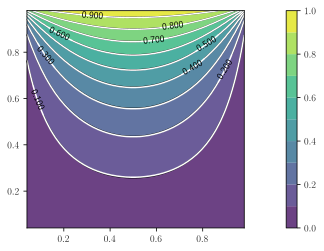

In [383]:
# Isolevels of concentration field
plt.figure(figsize=(6,4))       
plt.contourf(x[2:-1,2:-1],y[2:-1,2:-1],C_spatialpy[2:-1,2:-1],levels=numpy.arange(0,1.1,0.1), alpha=0.8)
plt.colorbar()
contours_sp = plt.contour(x[2:-1,2:-1],y[2:-1,2:-1],C_spatialpy[2:-1,2:-1],levels=numpy.arange(0,1.1,0.1), colors='black')
contours_exact =plt.contour(x[2:-1,2:-1],y[2:-1,2:-1],C_analytical[2:-1,2:-1],levels=numpy.arange(0,1.1,0.1), colors='white')

plt.clabel(contours_sp, inline=1,fontsize=10)

plt.axis('square');


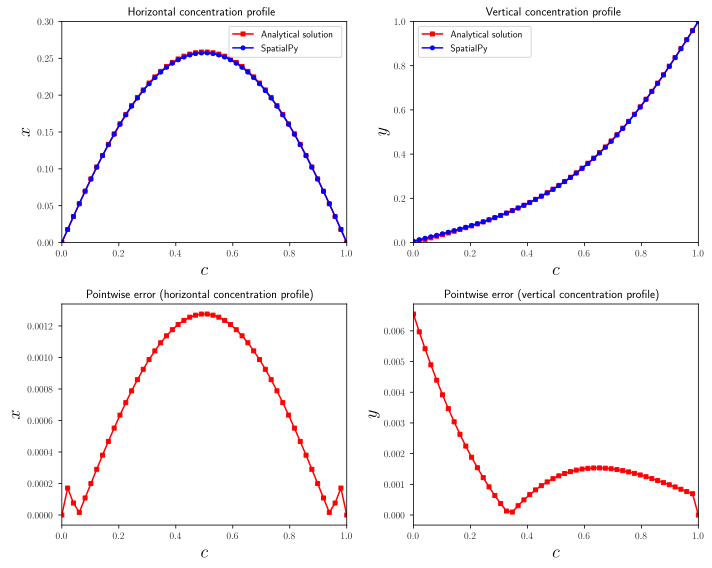

In [335]:
# Plot horizontal and vertical concentration profiles
%config InlineBackend.figure_format = 'svg'

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Horizontal profile
mid_length = math.ceil(len(x)/2)
axes[0,0].plot(x[mid_length,:],C_analytical[mid_length,:],'-rs',label='Analytical solution',markersize=4)
axes[0,0].plot(x[mid_length,:],C_spatialpy[mid_length,:],'-bo',label='SpatialPy',markersize=4)
axes[0,0].set_title('Horizontal concentration profile')
axes[0,0].set_xlabel(r'$c$',fontsize=18)
axes[0,0].set_ylabel(r'$x$',fontsize=18)
axes[0,0].set_xlim([0,1])
axes[0,0].set_ylim([0,0.3])
axes[0,0].legend()


# Pointwise absolute error (horizontal profile)
mid_length = math.ceil(len(x)/2)
axes[1,0].plot(y[:,mid_length],abs(C_analytical[mid_length,:]-C_spatialpy[mid_length,:]),'-rs',markersize=4)
axes[1,0].set_title('Pointwise error (horizontal concentration profile)')
axes[1,0].set_xlabel(r'$c$',fontsize=18)
axes[1,0].set_ylabel(r'$x$',fontsize=18)
axes[1,0].set_xlim([0,1])


# Vertical profile
mid_length = math.ceil(len(x)/2)
axes[0,1].plot(y[:,mid_length],C_analytical[:,mid_length],'-rs',label='Analytical solution',markersize=4)
axes[0,1].plot(y[:,mid_length],C_spatialpy[:,mid_length],'-bo',label='SpatialPy',markersize=4)
axes[0,1].set_title('Vertical concentration profile')
axes[0,1].set_xlabel(r'$c$',fontsize=18)
axes[0,1].set_ylabel(r'$y$',fontsize=18)
axes[0,1].set_xlim([0,1])
axes[0,1].set_ylim([0,1])
axes[0,1].legend()


# Pointwise absolute error (vertical profile)
mid_length = math.ceil(len(x)/2)
axes[1,1].plot(y[:,mid_length],abs(C_analytical[:,mid_length]-C_spatialpy[:,mid_length]),'-rs',markersize=4)
axes[1,1].set_title('Pointwise error (vertical concentration profile)')
axes[1,1].set_xlabel(r'$c$',fontsize=18)
axes[1,1].set_ylabel(r'$y$',fontsize=18)
axes[1,1].set_xlim([0,1])
fig.tight_layout()


